In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

# ---------------------------- reproducibility ---------------------------- #
np.random.seed(42)  # fixed seed for repeatable initial conditions

# ---------------------------- SEIR model ---------------------------- #
def seir_equations(y, beta, gamma, sigma, mu, nu):
    S, E, I, R = y
    N = 1.0
    dS_dt = mu * (N - S) - (beta * S * I / N) - nu * S
    dE_dt = (beta * S * I / N) - (mu + sigma) * E
    dI_dt = sigma * E - (mu + gamma) * I
    dR_dt = gamma * I - mu * R + nu * S
    return [dS_dt, dE_dt, dI_dt, dR_dt]

# ---------------------------- time grid ---------------------------- #
start_time = 0.0
end_time = 50.0
time_step = 0.2
t = np.arange(start_time, end_time, time_step)

# ---------------------------- solver ---------------------------- #
def eulermethod(seir_equations, initial_conditions, t, params):
    x = np.asarray(initial_conditions, dtype=float)
    xs = [x]
    for k in range(t.shape[0] - 1):
        dt = t[k + 1] - t[k]
        dS, dE, dI, dR = seir_equations(x, *params)
        x = [x[0] + dt * dS, x[1] + dt * dE, x[2] + dt * dI, x[3] + dt * dR]
        xs.append(x)
    xs = np.asarray(xs, dtype=float)
    return xs[:, 0], xs[:, 1], xs[:, 2], xs[:, 3]

# ---------------------------- data gen + save ---------------------------- #
def generate_and_save_data(
    t,
    num_simulations,
    split_ratio=0.5,
    output_dir="results"  # NEW parameter for folder
):
    """
    Generate synthetic SEIR trajectories and split into training/testing sets.

    Parameters
    ----------
    t : ndarray
        Time grid.
    num_simulations : int
        Number of trajectories to simulate.
    split_ratio : float
        Fraction of simulations to use for training.
    output_dir : str or Path
        Directory where results will be saved.

    Returns
    -------
    (train_data, test_data, train_initial_conditions, test_initial_conditions)
    """
    # Ensure directory exists
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # Filenames inside the chosen directory
    training_file = output_dir / "seir_training_data.npz"
    testing_file = output_dir / "seir_testing_data.npz"
    train_init_file = output_dir / "seir_train_initial_conditions.csv"
    test_init_file = output_dir / "seir_test_initial_conditions.csv"

    # Mean parameters
    beta_mean, gamma_mean, sigma_mean, mu_mean, nu_mean = 0.9, 0.2, 0.6, 0.3, 0.2

    T = t.shape[0]
    data = np.empty((num_simulations, T, 4), dtype=float)  # [S, E, I, R]
    initial_conditions_list = []

    for i in range(num_simulations):
        beta, gamma, sigma, mu, nu = beta_mean, gamma_mean, sigma_mean, mu_mean, nu_mean
        rnd = np.random.rand(4)
        ic = (rnd / rnd.sum()).tolist()
        initial_conditions_list.append(ic)

        S, E, I, R = eulermethod(seir_equations, ic, t, params=(beta, gamma, sigma, mu, nu))
        data[i, :, 0] = S
        data[i, :, 1] = E
        data[i, :, 2] = I
        data[i, :, 3] = R

    # Split
    num_train = int(num_simulations * split_ratio)
    train_data = data[:num_train]
    test_data = data[num_train:]
    train_initial_conditions = initial_conditions_list[:num_train]
    test_initial_conditions = initial_conditions_list[num_train:]

    # Save arrays
    np.savez(training_file, data=train_data)
    np.savez(testing_file, data=test_data)

    # Save ICs to CSV
    pd.DataFrame(train_initial_conditions, columns=["S0", "E0", "I0", "R0"]).to_csv(train_init_file, index=False)
    pd.DataFrame(test_initial_conditions, columns=["S0", "E0", "I0", "R0"]).to_csv(test_init_file, index=False)

    print(f"Saved results in: {output_dir.resolve()}")
    return train_data, test_data, train_initial_conditions, test_initial_conditions

# ---------------------------- run ---------------------------- #
if __name__ == "__main__":
    trajectories_train, trajectories_test, init_train, init_test = generate_and_save_data(
        t, num_simulations=200, split_ratio=0.5, output_dir="Data"
    )


Saved results in: /Users/dujianda/Desktop/Clean_FEX/Data


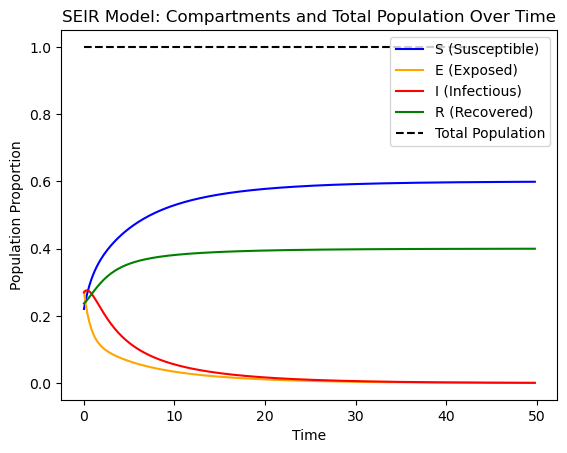

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load the saved training or testing data (example: loading training data)
data = np.load('Data/seir_training_data.npz')['data']  # You can load 'seird_testing_data.npz' similarly

# Time grid (ensure this matches the one used during data generation)
t = np.arange(0, 50, 0.2)

# Select the simulation you want to plot (e.g., the first simulation, index 0)
simulation_index = 49
S = data[simulation_index, :, 0]  # Susceptible
E = data[simulation_index, :, 1]
I = data[simulation_index, :, 2]  # Infectious
R = data[simulation_index, :, 3]  # Recovered

# Calculate the total population at each time step
total_population = S + E + I + R

# Plot each compartment
plt.plot(t, S, label='S (Susceptible)', color='blue')
plt.plot(t, E, label='E (Exposed)', color = 'orange')
plt.plot(t, I, label='I (Infectious)', color='red')
plt.plot(t, R, label='R (Recovered)', color='green')

# Plot the total population (should be constant if N=1)
plt.plot(t, total_population, label='Total Population', color='black', linestyle='--')

# Labels and title
plt.xlabel('Time')
plt.ylabel('Population Proportion')
plt.title('SEIR Model: Compartments and Total Population Over Time')
plt.legend(loc='best')

# Show the plot
plt.show()
# print(S)